### Neural Network Classification with PyTorch
What is classification? Classification is a problem of predicting whether something is one thing or another

## Make classification data and get it ready

In [26]:
import sklearn
from sklearn.datasets import make_circles
import pandas as pd

#1000 samples
n_samples=1000

#create samples
x,y=make_circles(n_samples,
                 noise=0.03,
                 random_state=42)

In [27]:
circles=pd.DataFrame({"x1":x[:,0],
                      "x2":x[:,1],
                      "label":y})
circles.head(10)

,x1,x2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


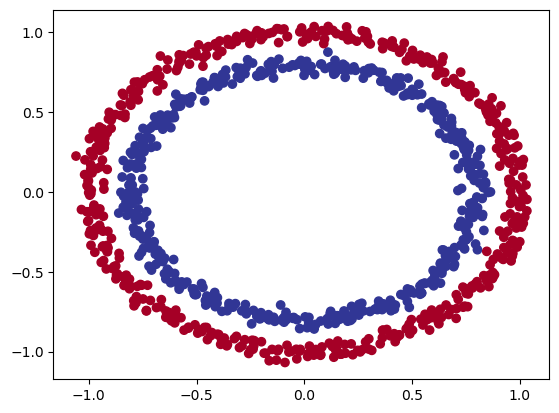

In [28]:
#visualize data
import matplotlib.pyplot as plt
plt.scatter(x=x[:,0],
            y=x[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)


##### converting data into tensors


In [29]:
import torch
x=torch.from_numpy(x).type(torch.float)
y=torch.from_numpy(y).type(torch.float)
x[:5],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [30]:
#split data into training and test set
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,
                                               y,
                                               test_size=0.2,
                                               random_state=42)

In [31]:
len(x_train),len(x_test),len(y_train),len(y_test)

(800, 200, 800, 200)

## Building a classiification model

Tasks:
1. Construct a model 
2. Define a loss function and optimizer
3. Create a training and testing loop


In [32]:
from torch import nn

#setup device agnostic code
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [33]:
# Construct a model
class CircleModel(nn.Module):
    def __init__(self) -> None:
        super().__init__() 
        #create 2 nn.Linear layers capable of handling the shapes of our data
        self.layer_1=nn.Linear(in_features=2,out_features=8)#takes in two features and upscales into 8 numbers
        self.layer_2=nn.Linear(in_features=8,out_features=1)#takes in 8 features from previous layer and outputs a single  number(same shape as y)
    # define a forward feature that outlines the forward pass
    def forward(self,x):
        return self.layer_2(self.layer_1(x)) #x->layer 1 ->layer2->output
    
#instantiate an instance of Circle model   
model=CircleModel().to(device)
model


CircleModel(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=1, bias=True)
)

In [34]:
device

'cpu'

In [35]:
model.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998]])),
             ('layer_1.bias',
              tensor([ 0.5451,  0.1045, -0.3301,  0.1802, -0.3258, -0.0829, -0.2872,  0.4691])),
             ('layer_2.weight',
              tensor([[-0.2791, -0.1630, -0.0998, -0.2126,  0.0334, -0.3492,  0.3193, -0.3003]])),
             ('layer_2.bias', tensor([0.2730]))])

In [36]:
#make an untrained prediction from the model
with torch.inference_mode():
    untrained_pred=model(x_test)
print(f'Length of prediction:{len(untrained_pred)},Shape:{untrained_pred.shape}')
print(f'first 20 labels:{untrained_pred[:10]}')

Length of prediction:200,Shape:torch.Size([200, 1])
first 20 labels:tensor([[-0.3104],
        [-0.4788],
        [ 0.1177],
        [-0.4316],
        [ 0.0967],
        [-0.0059],
        [-0.4633],
        [-0.3526],
        [ 0.1180],
        [-0.4903]])


#### Loss function and optimization

Loss fucntion used- Binary cross entropy(BCE) `torch.nn.BCEWithLogistsLoss()` it combines a Sigmoid layer and bce layer in one loss function.
 

In [37]:
#setup loss function
loss_fn=nn.BCEWithLogitsLoss()

# setup the optimizer
optimizer=torch.optim.SGD(params=model.parameters(),
                          lr=0.01)
#calculate accurracy-out of 100 examples how  many do we get right
def accuracy_fn(y_true,y_pred):
    correct=torch.eq(y_true,y_pred).sum().item()
    acc=(correct/len(y_pred)*100)
    return acc


### Training our model
for an epoch in a range of epochs
1. Forward pass
2. Calculate our loss
3. optimizer zero grad
4. back propagation
5. optimizer step

### Going from raw logits->prediction probabilities->prediction labels

Model output will be raw *logits*

we can convert these logits into prediction probabilities by passing them to some kind of activation function(eg.sigmoid for binary crossentropy and softmax for multiclass classification)

Then we can convert our model prediction probabilites to prediction labls by either rounding them(for binary classification) or taking the argmax()(for softmax)

###### for the prediction probabilities, a range-style rounding will be performed on them:
* if `y_pred_prob`>= 0.5 `y=1` (class 1)
* else `y=0` (class 2) 

In [38]:
#initialize epoch
torch.manual_seed(42)
epochs=1000
 
for epoch in range(epochs):
    model.train()
    #forward pass
    y_logits=model(x_train).squeeze()## will return logits
    #convert the logits into prediction values using the sigmoid activation function
    y_pred=torch.round(torch.sigmoid(y_logits))#logits->pred probs->pred probs->pred labels
    #calculate the loss/loss accuracy
    #nn.BCE with logits loss expects raw logits as input
    loss=loss_fn(y_logits 
                 ,y_train)
    acc=accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
    #optimizer zero grad
    optimizer.zero_grad()
    #loss backward(back propagation)
    loss.backward()
    #optimizer step(gradient descent)
    optimizer.step()

    #testing
    model.eval()
    with torch.inference_mode():
            #forward pass
            test_logits=model(x_test).squeeze()
            test_pred=torch.round(torch.sigmoid(test_logits))

            #calculate the test loss/accuracy
            test_loss=loss_fn(test_logits,
                              y_test)
            test_acc=accuracy_fn(y_true=y_test,
                                 y_pred=test_pred)
            
    #visualize
    if epoch %10==0:
           print(f'Epoch:{epoch}| Loss:{loss:.5f}|Acc:{acc:.2f}%|Test Loss:{test_loss:.5f}|Test_Acc:{test_acc:.2f}%')       

Epoch:0| Loss:0.70544|Acc:48.25%|Test Loss:0.69489|Test_Acc:53.00%
Epoch:10| Loss:0.70482|Acc:48.25%|Test Loss:0.69443|Test_Acc:53.50%
Epoch:20| Loss:0.70425|Acc:48.38%|Test Loss:0.69402|Test_Acc:54.00%
Epoch:30| Loss:0.70372|Acc:48.25%|Test Loss:0.69365|Test_Acc:53.50%
Epoch:40| Loss:0.70323|Acc:48.00%|Test Loss:0.69331|Test_Acc:53.00%
Epoch:50| Loss:0.70278|Acc:48.00%|Test Loss:0.69301|Test_Acc:53.00%
Epoch:60| Loss:0.70236|Acc:47.88%|Test Loss:0.69274|Test_Acc:53.00%
Epoch:70| Loss:0.70196|Acc:48.25%|Test Loss:0.69250|Test_Acc:52.00%
Epoch:80| Loss:0.70159|Acc:48.25%|Test Loss:0.69228|Test_Acc:52.50%
Epoch:90| Loss:0.70125|Acc:48.25%|Test Loss:0.69209|Test_Acc:52.50%
Epoch:100| Loss:0.70092|Acc:48.50%|Test Loss:0.69191|Test_Acc:53.00%
Epoch:110| Loss:0.70062|Acc:48.62%|Test Loss:0.69175|Test_Acc:53.00%
Epoch:120| Loss:0.70033|Acc:48.62%|Test Loss:0.69161|Test_Acc:53.00%
Epoch:130| Loss:0.70006|Acc:48.50%|Test Loss:0.69148|Test_Acc:53.00%
Epoch:140| Loss:0.69980|Acc:48.62%|Test Loss:

#### Visualizing our model to see the problems with its accuracy
Making use of plot decision boundaries

In [39]:
import requests
from pathlib import Path
#download a helper functions script from github
#check if the file already exists
if Path("helper_functions.py").is_file():
    print("File already exists")
else:
    print("Downloading helper_functions.py")
    #download the file from the github repository
    request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    # write the contents of the requests into a file
    with open ("helper_functions.py",'wb') as f:
        f.write(request.content)
    print('Operation succesful')    


File already exists


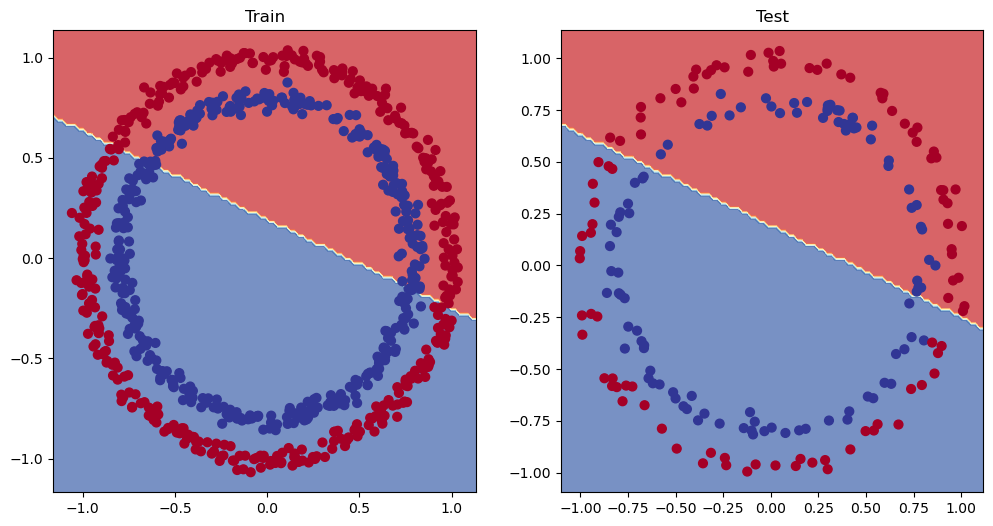

In [40]:
from helper_functions import plot_decision_boundary,plot_predictions

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model,x_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model,x_test,y_test)


#### Improving the model( from the model perspective)
what are the viable options?
* add more layers-give the model more chances to learn from the data
* add more hidden units 
* Fit for longer
* Changing the activation function
* Change the learning rate
* Change the loss function

# first Model improvement
* add more hidden units :8->16
* Increase the number of layer 2->3
* Increase the number of epochs 1000->2000

In [41]:
class CircleModelv1(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer_1=nn.Linear(in_features=2,out_features=16)
        self.layer_2=nn.Linear(in_features=16,out_features=16)
        self.layer3=nn.Linear(in_features=16,out_features=1)

    def forward(self,X):
    
        return self.layer3(self.layer_2(self.layer_1(x)))  

In [42]:
modelv1=CircleModelv1()
modelv1

CircleModelv1(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=1, bias=True)
)

In [ ]:
#create a loss funtion
lossv1=nn.BCEWithLogitsLoss()
#create an optimizer 
optimizerv1=torch.optim.SGD(params=modelv1.parameters(),
                            lr=0.001
                            )
#write a training and testing loop
torch.manual_seed(42)

epochsv1=2000
for epoch in range(epochsv1):
    modelv1.train()
    #model forward pass
    yv1_logits=modelv1(x_train).squeeze()
    y_predv1=torch.round(torch.sigmoid(yv1_logits))
    #calculate the loss/accuracy
    lv1=loss_fn(yv1_logits, y_train)
    v1acc=accuracy_fn(y_true=y_train,y_pred=y_predv1)

    #optimizer zero grad
    optimizerv1.zero_grad()

    #back propagation
    loss.backward()

    #test loop
    modelv1.eval()
    with torch.inference_mode():
         #test forward pass
        testv1_logits=modelv1(x_test).squeeze()
        testv1_pred=torch.round(torch.sigmoid(testv1_logits))
        #test loss/accuracy
        testv1_loss=loss_fn(testv1_logits,y_test)
        testv1_acc=accuracy_fn(y_true=y_test,y_pred=testv1_pred)

    #visualize
    if epoch % 100==0:
        print(f'Epoch:{epoch}|v1loss:{lv1:.5f}|v1acc:{v1acc:.2f}%|testv1loss:{testv1_loss:.5f}|testv1_acc:{testv1_acc:.2f}%')

    